In [2]:
%load_ext zipline

[2018-10-22 16:06:07.915001] INFO: zipline.finance.metrics.tracker: Simulated 755 trading days
first open: 2015-01-02 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00


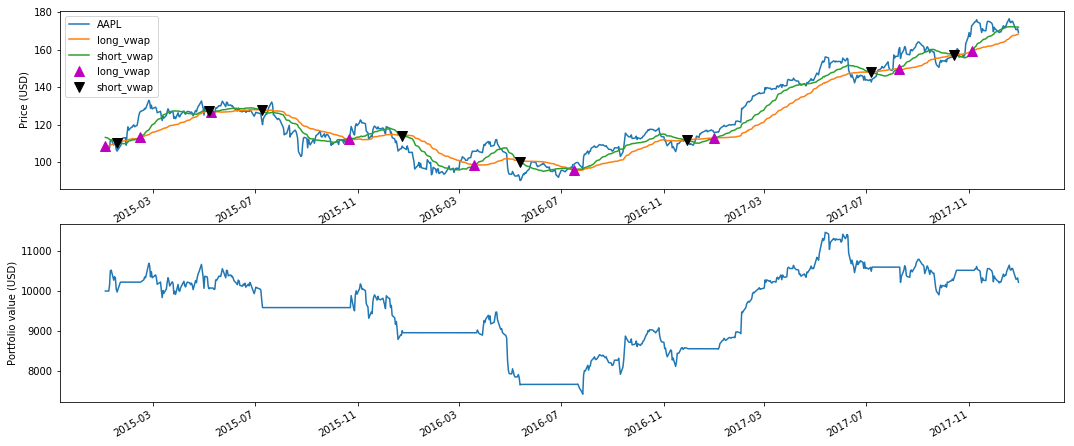

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,buy,capital_used,ending_cash,...,short_value,short_vwap,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,109.330,NaN,0.000000,NaN,-0.000535,NaN,NaN,True,0.00,10000.00,...,0.0,113.276434,0,NaN,10000.00,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,106.250,0.001122,-0.000100,0.000769,-0.018585,0.196720,0.005706,False,-9669.75,330.25,...,0.0,112.930354,0,-11.224972,10000.00,0.00,0.00,2,"[{u'commission': None, u'amount': 91, u'sid': ...",0.0
2015-01-06 21:00:00+00:00,106.260,0.001517,-0.000009,0.012496,-0.027829,0.139106,0.005631,False,0.00,330.25,...,0.0,112.538990,0,-0.824030,330.25,9668.75,9668.75,3,[],0.0
2015-01-07 21:00:00+00:00,107.750,0.107653,0.013550,1.281330,-0.015715,0.206973,0.436484,False,0.00,330.25,...,0.0,112.257172,0,1075.508314,330.25,9669.66,9669.66,4,[],0.0
2015-01-08 21:00:00+00:00,111.890,0.257318,0.051224,2.455441,0.001752,0.236042,0.912806,False,0.00,330.25,...,0.0,112.039901,0,3600.796372,330.25,9805.25,9805.25,5,[],0.0
2015-01-09 21:00:00+00:00,112.010,0.237596,0.052316,2.399587,-0.006276,0.218112,0.923179,False,0.00,330.25,...,0.0,111.779409,0,3354.383556,330.25,10181.99,10181.99,6,[],0.0
2015-01-12 21:00:00+00:00,109.250,0.291640,0.027200,1.534764,-0.014060,0.203322,1.079522,False,0.00,330.25,...,0.0,111.496169,0,7.011668,330.25,10192.91,10192.91,7,[],0.0
2015-01-13 21:00:00+00:00,110.220,0.271242,0.036027,1.707050,-0.016834,0.188302,1.075280,False,0.00,330.25,...,0.0,111.319247,0,8.579531,330.25,9941.75,9941.75,8,[],0.0
2015-01-14 21:00:00+00:00,109.800,0.257452,0.032205,1.604705,-0.022769,0.177394,1.089340,False,0.00,330.25,...,0.0,111.058649,0,7.185650,330.25,10030.02,10030.02,9,[],0.0
2015-01-15 21:00:00+00:00,106.820,0.285429,0.005087,1.138004,-0.031722,0.170558,1.220089,False,0.00,330.25,...,0.0,110.746177,0,0.917759,330.25,9991.80,9991.80,10,[],0.0


In [15]:
%%zipline --start 2015-1-1 --end 2018-1-1  --capital-base 10000 -o ../data/strategy3.1.pickle

"""Dual Moving Average Crossover algorithm.

This algorithm buys apple once its short moving average crosses
its long moving average (indicating upwards momentum) and sells
its shares once the averages cross again (indicating downwards
momentum).

"""

from zipline.api import order, record, symbol, order_target_percent
from zipline.finance import commission, slippage
# Import exponential moving average from talib wrapper
from talib import EMA


def initialize(context):
    context.asset = symbol('AAPL')

    # To keep track of whether we invested in the stock or not
    context.invested = False
 
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())

def vwap(prices, volumes):
    return (prices * volumes).sum() / volumes.sum()


def handle_data(context, data):
    long_win = 60
    short_win = 30
    trailing_window = data.history(context.asset, fields=['price','volume'], bar_count=long_win, frequency='1d')
             
    if trailing_window.isnull().values.any():
        return
    
    short_vwap = vwap(trailing_window['price'][-short_win:], \
                      trailing_window['volume'][-short_win:]) 
    long_vwap = vwap(trailing_window['price'], \
                      trailing_window['volume'])  
    
    buy = False
    sell = False

    if (short_vwap > long_vwap) and not context.invested:
        #order(context.asset, 100)
        order_target_percent(context.asset, 1)
        context.invested = True
        buy = True
    elif (short_vwap < long_vwap) and context.invested:
        #order(context.asset, -100) 
        order_target_percent(context.asset, 0)
        context.invested = False
        sell = True

    record(AAPL=data.current(context.asset, "price"),
           short_vwap=short_vwap,
           long_vwap=long_vwap,
           buy=buy,
           sell=sell)


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(212)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(211)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if 'AAPL' in results and 'long_vwap' in results and 'short_vwap' in results:
        results[['AAPL', 'long_vwap', 'short_vwap']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'long_vwap'],
            '^',
            markersize=10,
            color='m',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'short_vwap'],
            'v',
            markersize=10,
            color='k',
        )
        plt.legend(loc=0)
        plt.gcf().set_size_inches(18, 8)
    else:
        msg = 'AAPL, short_vwap and long_vwap data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)
    plt.gcf().set_size_inches(18, 8)
    plt.show() 

In [16]:
import pandas as pd
perf = pd.read_pickle('../data/strategy3.1.pickle')
print("Benchmark:{}, Our strategy: {}".format(perf['benchmark_period_return'][-1], perf['algorithm_period_return'][-1]))
perf[['benchmark_period_return','algorithm_period_return']]

Benchmark:0.379827139153, Our strategy: 0.0217049999889


,benchmark_period_return,algorithm_period_return
2015-01-02 21:00:00+00:00,-0.000535,0.000000
2015-01-05 21:00:00+00:00,-0.018585,-0.000100
2015-01-06 21:00:00+00:00,-0.027829,-0.000009
2015-01-07 21:00:00+00:00,-0.015715,0.013550
2015-01-08 21:00:00+00:00,0.001752,0.051224
2015-01-09 21:00:00+00:00,-0.006276,0.052316
2015-01-12 21:00:00+00:00,-0.014060,0.027200
2015-01-13 21:00:00+00:00,-0.016834,0.036027
2015-01-14 21:00:00+00:00,-0.022769,0.032205
2015-01-15 21:00:00+00:00,-0.031722,0.005087
